In [46]:
import torch,torchvision
import numpy as np
import pandas as pd

## 1.Table
#### Read data

In [4]:
from sklearn import datasets
iris = datasets.load_iris()
#x
iris.data
#y
iris.target

#### One-hot encoding:

In [387]:
tensor_iris = torch.from_numpy(iris.data)
y = torch.from_numpy(iris.target)
y_onethot = torch.zeros(tensor_iris.shape[0],3)
y_onethot.scatter_(1,y.unsqueeze(1),1)# dim,index,src

##### 有下底線的都是in-place

In [72]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
#enc.fit(y.reshape(1,-1))
y_onehot = enc.fit_transform(y.reshape(-1,1)).toarray()

#### 敘述統計

In [76]:
tensor_iris.mean(dim=0)

tensor([5.8433, 3.0540, 3.7587, 1.1987], dtype=torch.float64)

In [78]:
tensor_iris.var(dim=0)

tensor([0.6857, 0.1880, 3.1132, 0.5824], dtype=torch.float64)

#### 小於等於

In [82]:
torch.le(tensor_iris[:,0],6)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1], dtype=torch.uint8)

In [85]:
#tensor_iris[torch.le(tensor_iris[:,0],6),:1]

In [87]:
s,indice = torch.sort(tensor_iris[:,0])

## 2. Time Series

#### numpy

In [142]:
bikes_numpy = np.loadtxt("Bike-Sharing-Dataset/hour.csv", dtype=np.float32, delimiter=",", skiprows=1,converters={1: lambda x: float(x[8:10])})
bikes = torch.from_numpy(bikes_numpy)

#### pandas

In [96]:
bikes = pd.read_csv("Bike-Sharing-Dataset/hour.csv")
bikes.dteday = bikes.dteday.apply(func=lambda x:int(x[8:10]))
bikes = torch.from_numpy(bikes.values)

In [149]:
import itertools
with open("Bike-Sharing-Dataset/hour.csv","rt") as f:
    res = [l for l in itertools.islice(f,0,1)]

In [143]:
#sort index
_, sorted_row_idxs = torch.sort(bikes[:, 0], dim=0)
bikes = bikes[sorted_row_idxs]
#subset
bikes = bikes[324:396,:]
#reshape
daily_bikes = bikes.view(-1, 24, bikes.shape[1]) #(3,24,17)
daily_bikes = daily_bikes.transpose(1, 2) #(3,17,24)

one-hot-encoding for category feature

In [136]:
daily_weather_onehot = torch.zeros(daily_bikes.shape[0], 4, daily_bikes.shape[2]) # (3,4,24)
daily_weather_onehot.scatter_(1, daily_bikes[:,9,:].long().unsqueeze(1) - 1, 1.0) # (3,4,24)
daily_bikes = torch.cat((daily_bikes, daily_weather_onehot), 1) # (3,21,24)

## Text

In [338]:
import unicodedata
import string
string.ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [341]:
all_letters = string.ascii_letters + " .,l'"
n_letters = len(all_letters) #57
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if 
                   unicodedata.category(c) != 'Mn' and c in all_letters)

* unicode category reference :   
https://en.wikipedia.org/wiki/Unicode_character_property
* unicode 正規化 :   
https://zh.wikipedia.org/wiki/Unicode%E7%AD%89%E5%83%B9%E6%80%A7

In [343]:
line = "This cöürse is really Äwesome. I like it so much, I really love it!"
unicode_to_ascii(line)

'This course is really Awesome. I like it so much, I really love it'

In [342]:
line = "This course is really aewsome. I like it so much, I really love it!"
tensor = torch.zeros(len(line), n_letters)
for i, letter in enumerate(line.lower().strip()):
    letter_index = all_letters.find(letter)
    tensor[i][letter_index] = 1

In [344]:
"defggresc".find('re')

5

In [122]:
from collections import Counter
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
wordli = [l for l in line.lower().split() if l not in stop]

如果想呈現多個詞，可以整理成(sentence_length,n_sentences,n_letters)

In [64]:
text ='''
A management information system (MIS) is an information system[1] used for decision-making, and for the coordination, control, analysis, and visualization of information in an organization; especially in a company.
The study of management information systems examines people and technology in an organizational context.[2]
In a corporate setting, the ultimate goal of the use of a management information system is to increase the value and profits of the business.[3]
'''

all_words = set(text.lower().replace('\n',' ').split())
punctuation = '.,;:"!?”“_-()'
all_words = {word.strip(punctuation): i for (i, word) in enumerate(all_words)}


In [349]:
"cdefvjaaa".strip('ac')

'defvj'

In [164]:
lines = text.strip().split('\n')

line = lines[0]
words_in_line = [word.strip(punctuation) for word in line.lower().split(' ')]
#words_in_line

tensor = torch.zeros(len(words_in_line), len(all_words))

for i, word in enumerate(words_in_line):
    word_index = all_words[word]
    tensor[i][word_index] = 1

## Audio

* Ref: https://musicinformationretrieval.com/

* Sampling Frequency : 採樣率，每秒紀錄的點(通常為44100 Hz)

In [50]:
import IPython.display as ipd
import librosa, librosa.display
import matplotlib.pyplot as plt

In [59]:
megadeth,sr = librosa.load('Megadeth - (02)Set The World Afire.mp3',offset=0,duration=80)
ipd.Audio(megadeth, rate=sr)

## Audio representation
1. time domain
2. frequency domain

#### FFT transform

In [222]:
from scipy import signal
f_arr, t_arr, sp_arr = signal.spectrogram(x, sr)

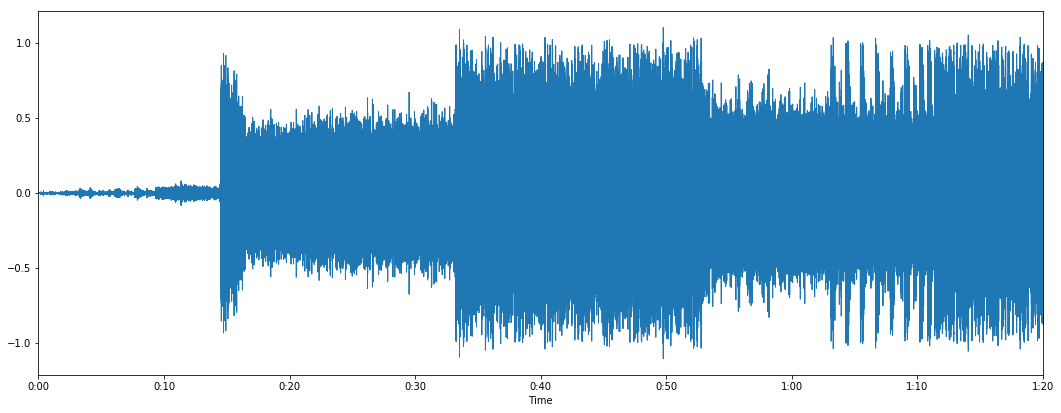

In [56]:
plt.figure(figsize=(18,6.7))
librosa.display.waveplot(megadeth)
plt.show()

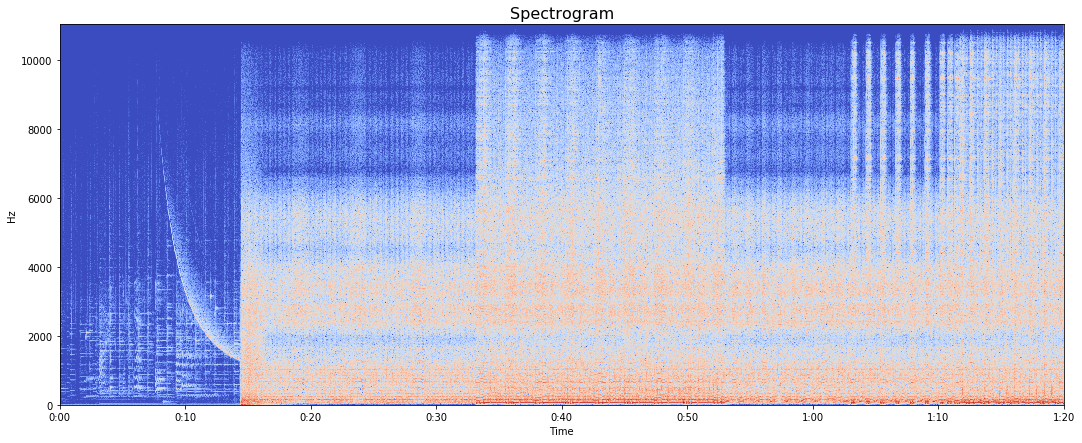

In [52]:
Y = librosa.stft(megadeth)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(18, 7))
plt.title("Spectrogram",fontsize=16)
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')
plt.show()

<br><br><br><br><br><br><br><br><br><br>
## Image

In [35]:
from IPython.display import Image
Image(url= "cat.jpg",width=500)

PyTorch modules dealing with image data require tensors to be laid out as C x H x W

In [25]:
import imageio
img_arr = imageio.imread('cat.jpg') #(463,600,3)
img = torch.from_numpy(img_arr)
out = torch.transpose(img, 0, 2) #(3,600,463)

#### pre-allocate a tensor of appropriate sizw and fill it with images loaded from a directory

In [249]:
batch_size = 100
batch = torch.ByteTensor(100, 3, 256, 256)

正規化後通常表現會比較好(要變浮點數)，有兩種方法：
* 除以最大值
* 減平均數除標準差(對每一channel)

In [262]:
batch = batch.float()
batch/255

In [ ]:
n_channels = batch.shape[1]
for c in range(n_channels):
    mean = torch.mean(batch[:, c])
    std = torch.std(batch[:, c])
    batch[:, c] = (batch[:, c] - mean) / std

## Volumetric Data
* 3D的影像，ex. 3D斷層掃描
* 可以視為許多2D影像一層一層疊起來
* DICOM : 醫療數位影像傳輸協定
* 以tensor的概念來考慮，就只是比圖片多一維度: depth
* dimension : BxCxDxHxW

In [28]:
imageio.volread(dirname, 'DICOM')

WxHxD -> BxCxDxHxW

## Video Data

In [30]:
import pylab
import imageio
from IPython.display import HTML

In [31]:
#  <video controls src="how.mp4" />

<video controls src="how.mp4" />

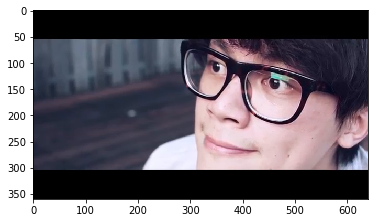

In [33]:
vid = imageio.get_reader('how.mp4')
image = vid.get_data(250)
pylab.imshow(image)
pylab.show()

In [301]:
vid.get_meta_data()

{'plugin': 'ffmpeg',
 'nframes': 305,
 'ffmpeg_version': '2.8.15-0ubuntu0.16.04.1 built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609',
 'fps': 29.97,
 'source_size': (640, 360),
 'size': (640, 360),
 'duration': 10.19}

In [331]:
w,h = vid.get_meta_data()['size']
t = vid.get_meta_data()['nframes']

In [332]:
how = torch.zeros(1,3,t,h,w)

In [333]:
for no,frame in enumerate(vid.iter_data()):
    how[0,:,no,:,:] = torch.from_numpy(frame.transpose(2,0,1,))

/home/hyades/anaconda3/lib/python3.6/site-packages/imageio/core/format.py:403: UserWarning: Could not read last frame of /home/hyades/Documents/py/pytorch/how.mp4.
  warn('Could not read last frame of %s.' % uri)


In [45]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # 数据库模块
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1           # 训练整批数据多少次, 为了节约时间, 我们只训练一次
BATCH_SIZE = 50
LR = 0.001          # 学习率
DOWNLOAD_MNIST = True  # 如果你已经下载好了mnist数据就写上 False


# Mnist 手写数字
train_data = torchvision.datasets.MNIST(
    root='./mnist/',    # 保存或者提取位置
    train=True,  # this is training data
    transform=torchvision.transforms.ToTensor(),    # 转换 PIL.Image or numpy.ndarray 成
                                                    # torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
    download=DOWNLOAD_MNIST,          # 没下载就下载, 下载了就不用再下了
)

Processing...
Done!


In [ ]:
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)

# 批训练 50samples, 1 channel, 28x28 (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# 为了节约时间, 我们测试时只测试前2000个
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]